Dataset Name:
sx-stackoverflow


Types of Interactions:

- sx-stackoverflow-a2q: User u answered user v's question at time t.

- sx-stackoverflow-c2q: User u commented on user v's question at time t.

- sx-stackoverflow-c2a: User u commented on user v's answer at time t.

# Loading the Dataset

In [85]:
# Reading the first few lines of the uploaded file to understand its structure
with open("./stack_limited.txt", "r") as file:
    sample_lines = [file.readline().strip() for _ in range(10)]

sample_lines

['9 8 1217567877',
 '1 1 1217573801',
 '13 1 1217606247',
 '17 1 1217617639',
 '48 2 1217618182',
 '17 1 1217618239',
 '19 9 1217618357',
 '13 23 1217618560',
 '13 11 1217618799',
 '23 23 1217619360']

The uploaded file appears to have a simple structure where each line represents an interaction, with the format:

Source User ID
Target User ID
Timestamp
Source User IDTarget User IDTimestamp

For example, in the first line:

Source User ID: 9
Target User ID: 8
Timestamp: 1217567877 (This seems to be a Unix timestamp, representing seconds since the epoch)

To further understand the dataset, we can perform some basic analyses:

- Get a distribution of the number of interactions per user.
- Identify the earliest and latest timestamps in the dataset to understand the time range.
- Determine the most active users (based on the number of interactions they've had).

In [86]:
import pandas as pd

# Loading the data into a DataFrame
column_names = ['Source', 'Target', 'Timestamp']
df = pd.read_csv("./stack_limited.txt", sep=' ', header=None, names=column_names)

# 1. Distribution of interactions per user (both as a source and target)
interaction_counts_source = df['Source'].value_counts()
interaction_counts_target = df['Target'].value_counts()
total_interactions = interaction_counts_source.add(interaction_counts_target, fill_value=0)

# 2. Identify the earliest and latest timestamps
earliest_timestamp = pd.to_datetime(df['Timestamp'].min(), unit='s')
latest_timestamp = pd.to_datetime(df['Timestamp'].max(), unit='s')

# 3. Determine the most active users
most_active_users = total_interactions.nlargest(5)

print("Time Range")
earliest_timestamp, latest_timestamp

Time Range


(Timestamp('2008-08-01 05:17:57'), Timestamp('2008-10-15 16:19:32'))

## Time Range

In [87]:
time_period = [earliest_timestamp, latest_timestamp]
time_period

[Timestamp('2008-08-01 05:17:57'), Timestamp('2008-10-15 16:19:32')]

## Most Active Users

In [88]:
print("Most Active Users:\n")
print("User  - Interactions")
print(most_active_users)

Most Active Users:

User  - Interactions
3043    626.0
572     604.0
1965    571.0
91      458.0
3153    429.0
dtype: float64


In [89]:
total_interactions.describe()

count    11713.000000
mean        17.075045
std         31.964292
min          1.000000
25%          2.000000
50%          7.000000
75%         18.000000
max        626.000000
dtype: float64

Interactions per User:
- On average, each user has around 17 interactions.
- The user with the fewest interactions has just 1 interaction.
- 25% of the users have 2 or fewer interactions.
- 50% (or the median) of the users have 7 interactions.
- 75% of the users have up to 18 interactions.
- The most active user has a whopping 626 interactions.

## distribution of interactions per user

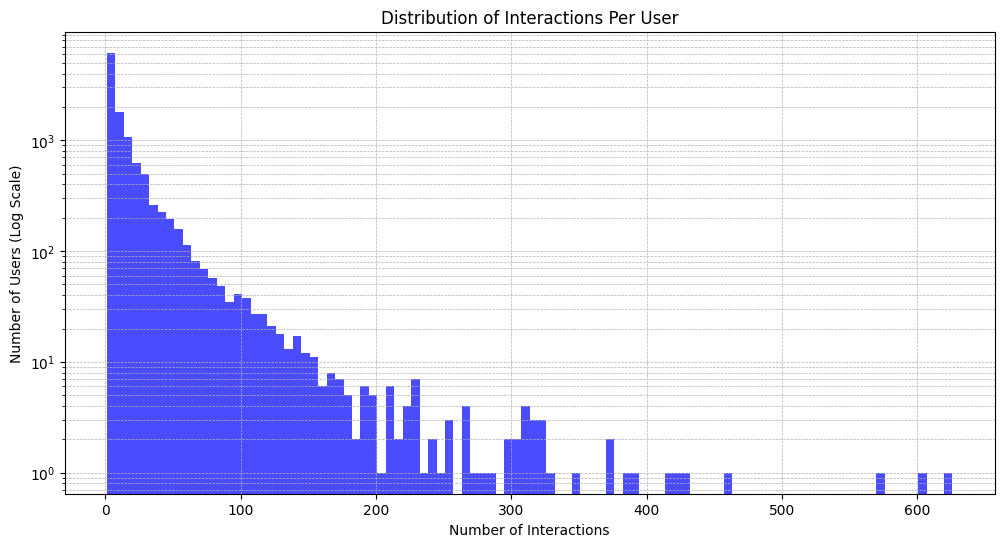

In [90]:
import matplotlib.pyplot as plt

# Plotting distribution of interactions per user
plt.figure(figsize=(12, 6))
plt.hist(total_interactions, bins=100, color='blue', alpha=0.7)
plt.yscale('log')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users (Log Scale)')
plt.title('Distribution of Interactions Per User')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

From the histogram we can see the following:

- A large number of users have very few interactions (between 1 and around 50). This is common in many online platforms where a majority of users are less active.
- As the number of interactions increases, the number of users having those interactions decreases. This is evident from the rapidly declining histogram bars.
- Very few users have extremely high interactions, but they can be considered as the "power users" or the most active members of the community.

This kind of distribution is typical of many social networks and online platforms, where a small percentage of users contribute a significant portion of the content or interactions, often referred to as the "80-20" rule or Pareto principle.

# Interactions over time

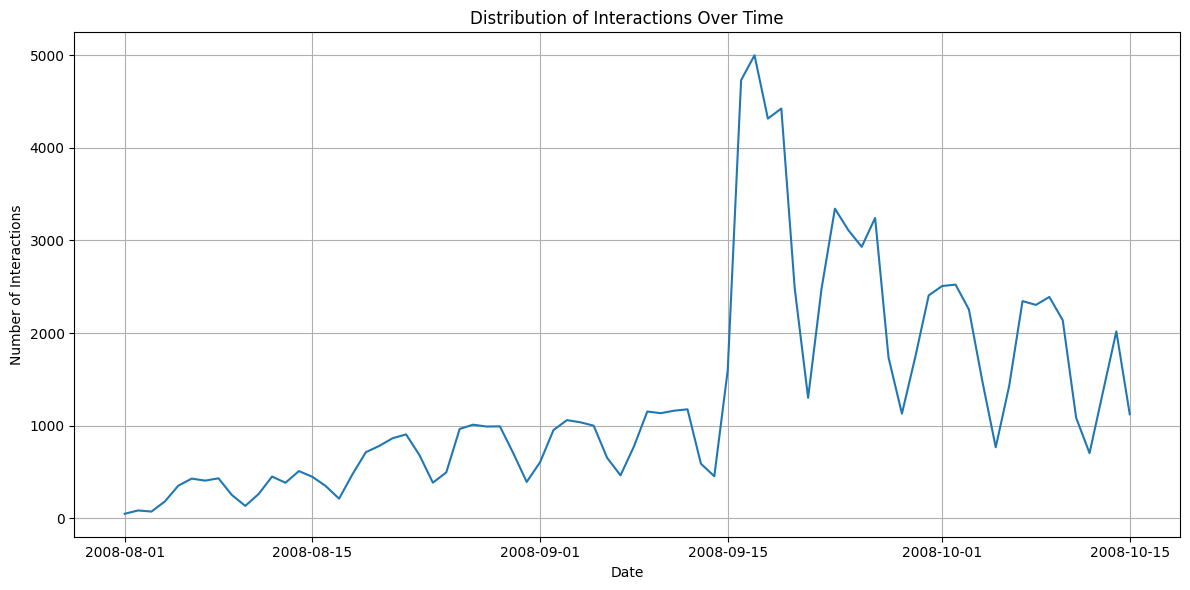

In [91]:
# Converting the timestamp column to a datetime format for easier analysis
df['datetime'] = pd.to_datetime(df['Timestamp'], unit='s')


# Plotting the distribution of interactions over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df.groupby(df['datetime'].dt.date).size().plot()
plt.title('Distribution of Interactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.grid(True)
plt.tight_layout()

- Interaction Distribution: The plot shows the distribution of interactions over time. We can observe a general upward trend in interactions, with some notable peaks.

# Splitting out Time Intances Data 

We will use the Uniform Time Intervals:

Divide the entire time range into N equal intervals.
This approach ensures that each interval has the same length but does not guarantee an even distribution of events across intervals.

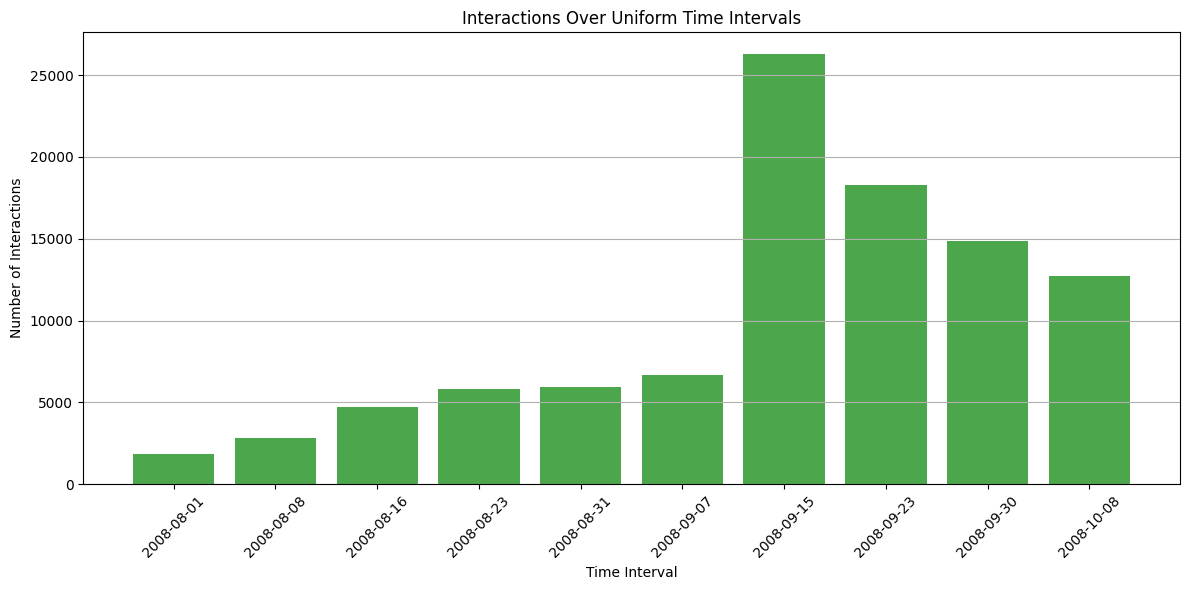

In [92]:
# Setting the number of intervals
N = 10

# Calculating the length of each interval
total_seconds = (latest_timestamp - earliest_timestamp).total_seconds()
interval_length = total_seconds / N

# Creating the time intervals
intervals = [earliest_timestamp + pd.to_timedelta(i * interval_length, unit='s') for i in range(N+1)]

# Counting the number of interactions in each interval
interaction_counts = []
for i in range(N):
    count = df[(df['Timestamp'] >= intervals[i].timestamp()) & (df['Timestamp'] < intervals[i+1].timestamp())].shape[0]
    interaction_counts.append(count)

# Plotting the interactions over the intervals
plt.figure(figsize=(12, 6))
plt.bar(range(N), interaction_counts, color='green', alpha=0.7)
plt.xticks(range(N), [str(intervals[i].date()) for i in range(N)], rotation=45)
plt.xlabel('Time Interval')
plt.ylabel('Number of Interactions')
plt.title('Interactions Over Uniform Time Intervals')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

Observations:

- There's a noticeable pattern where activity seems to increase in the middle intervals and then decrease towards the end. This could be due to various factors, such as day of the week effects, special events, or platform changes.
- The highest activity level occurs around the interval starting from September 1, 2008.

## Define individual graph objects for the time intervals

#### ll be using the networkx library to create these graph objects. 

In [93]:
import networkx as nx

# Creating individual graph objects for each time interval
graphs = []

for i in range(N):
    # Filter interactions for the current interval
    interval_data = df[(df['Timestamp'] >= intervals[i].timestamp()) & (df['Timestamp'] < intervals[i+1].timestamp())]
    
    # Create a directed graph for the interval
    G = nx.from_pandas_edgelist(interval_data, 'Source', 'Target', create_using=nx.DiGraph())
    graphs.append(G)

# Checking the number of nodes and edges in each graph
graph_info = [(len(G.nodes()), len(G.edges())) for G in graphs]

In [94]:
print("Total Nodes - Total Edges")
print(graph_info)

Total Nodes - Total Edges
[(402, 1669), (710, 2537), (1141, 4357), (1598, 5429), (1792, 5571), (1976, 6361), (6891, 25326), (5312, 17609), (4917, 14327), (4685, 12338)]


In [95]:
print("Our Graphs")
graphs

Our Graphs


# Sample our graphs (Optional to make things faster)

# 500 is a sweat spot were we are not taking ages to compute but the images are still impresive

In [96]:
from random import sample

sample_size = 500
# Sampling nodes from each graph
sampled_graphs = []

for G in graphs:
    # Ensure there are enough nodes to sample from
    if len(G.nodes()) > sample_size:
        # Randomly select nodes
        sampled_nodes = sample(G.nodes(), sample_size)
        # Create a subgraph with the sampled nodes
        SG = G.subgraph(sampled_nodes)
        sampled_graphs.append(SG)
    else:
        # If there aren't enough nodes, use the original graph
        sampled_graphs.append(G)

# Now, `sampled_graphs` contains the sampled subgraphs or the original graphs if they were small enough.
graphs = sampled_graphs

/tmp/ipykernel_14864/3194214545.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = sample(G.nodes(), sample_size)


# for each graph take the edges E1,E2,...En and the unique nodes  V1,V2...Vn


In [97]:
# Extracting edges and unique nodes for each graph
edges_list = [list(G.edges()) for G in graphs]
nodes_list = [list(G.nodes()) for G in graphs]

# Centrality Analysis

Centrality analysis helps us identify the most important nodes in a network. There are various centrality measures, each capturing different types of "importance" or "influence" of a node within a network.

For this analysis, we'll focus on the following centrality measures:

- Degree Centrality: The number of links incident upon a node.
- Betweenness Centrality: The number of times a node acts as a bridge along the shortest path between two other nodes.
- Eigenvector Centrality: A measure of the influence of a node in a network.

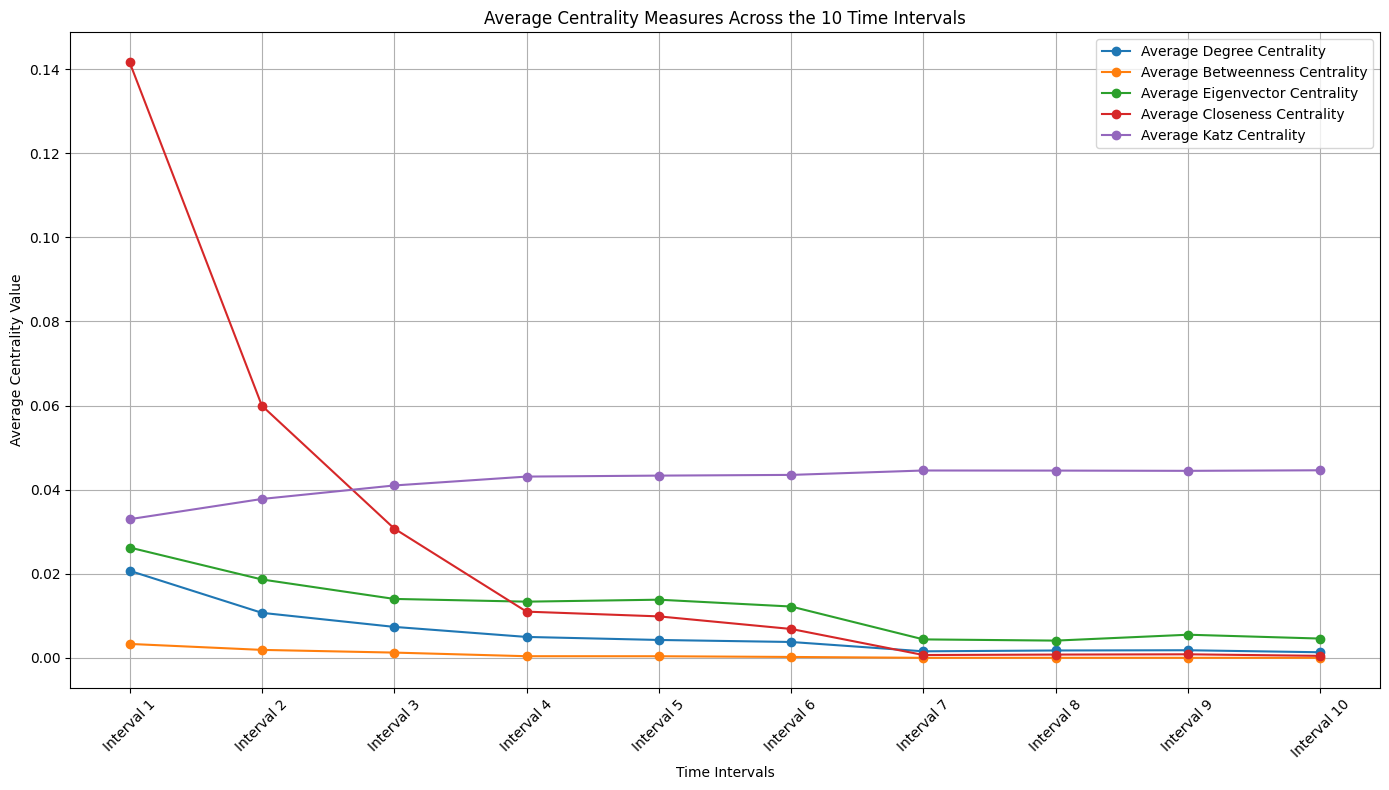

In [98]:
# Calculating centrality measures for each graph

degree_centralities = [nx.degree_centrality(G) for G in graphs]
betweenness_centralities = [nx.betweenness_centrality(G, normalized=True, endpoints=False) for G in graphs]
eigenvector_centralities = [nx.eigenvector_centrality(G, max_iter=1000) if len(G) > 0 else {} for G in graphs]
closeness_centralities = [nx.closeness_centrality(G) for G in graphs]
katz_centralities = [nx.katz_centrality(G, max_iter=1000) if len(G) > 0 else {} for G in graphs]


# Averaging the centrality measures for visualization
avg_degree = [sum(dc.values())/len(dc) if len(dc) > 0 else 0 for dc in degree_centralities]
avg_betweenness = [sum(bc.values())/len(bc) if len(bc) > 0 else 0 for bc in betweenness_centralities]
avg_eigenvector = [sum(ec.values())/len(ec) if len(ec) > 0 else 0 for ec in eigenvector_centralities]
avg_closeness = [sum(cc.values())/len(cc) if len(cc) > 0 else 0 for cc in closeness_centralities]
avg_katz = [sum(kc.values())/len(kc) if len(kc) > 0 else 0 for kc in katz_centralities]


# Visualizing the average centrality measures across the 10 intervals
plt.figure(figsize=(14, 8))

plt.plot(avg_degree, '-o', label='Average Degree Centrality')
plt.plot(avg_betweenness, '-o', label='Average Betweenness Centrality')
plt.plot(avg_eigenvector, '-o', label='Average Eigenvector Centrality')
plt.plot(avg_closeness, '-o', label='Average Closeness Centrality')
plt.plot(avg_katz, '-o', label='Average Katz Centrality')

plt.title('Average Centrality Measures Across the 10 Time Intervals')
plt.xlabel('Time Intervals')
plt.ylabel('Average Centrality Value')
plt.xticks(ticks=range(10), labels=[f"Interval {i+1}" for i in range(10)], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## The Kullback-Leibler (KL) divergence


The Kullback-Leibler (KL) divergence is a measure of how one probability distribution diverges from a second expected probability distribution. It's commonly used in statistics to measure the difference between two distributions. However, it's essential to note that the KL divergence is not symmetric, meaning
 (P∣∣Q) is not the same as (Q∣∣P).
In the context of comparing two graphs, we can use the KL divergence to compare the distributions of centrality measures (like degree distribution) between the two graphs.

In [99]:
import numpy as np


# Randomly select two graphs 0 and 1
random_graph_indices = [0,1]
G1, G2 = graphs[random_graph_indices[0]], graphs[random_graph_indices[1]]

# Get the degree distributions of the two graphs
degree_distribution_G1 = nx.degree_histogram(G1)
degree_distribution_G2 = nx.degree_histogram(G2)

# Normalize the distributions to make them probability distributions
degree_distribution_G1 = np.array(degree_distribution_G1) / sum(degree_distribution_G1)
degree_distribution_G2 = np.array(degree_distribution_G2) / sum(degree_distribution_G2)

# To compute KL divergence, we need to ensure that the distributions have the same length 
# and there are no zeros (to avoid division by zero or log(0))
length = max(len(degree_distribution_G1), len(degree_distribution_G2))
degree_distribution_G1 = np.resize(degree_distribution_G1, length)
degree_distribution_G2 = np.resize(degree_distribution_G2, length)

# Adding a small value to distributions to avoid log(0)
epsilon = 1e-10
degree_distribution_G1 += epsilon
degree_distribution_G2 += epsilon

# Compute KL divergence
kl_divergence = sum(degree_distribution_G1 * np.log(degree_distribution_G1 / degree_distribution_G2))

random_graph_indices, kl_divergence

([0, 1], 0.8480467182884912)

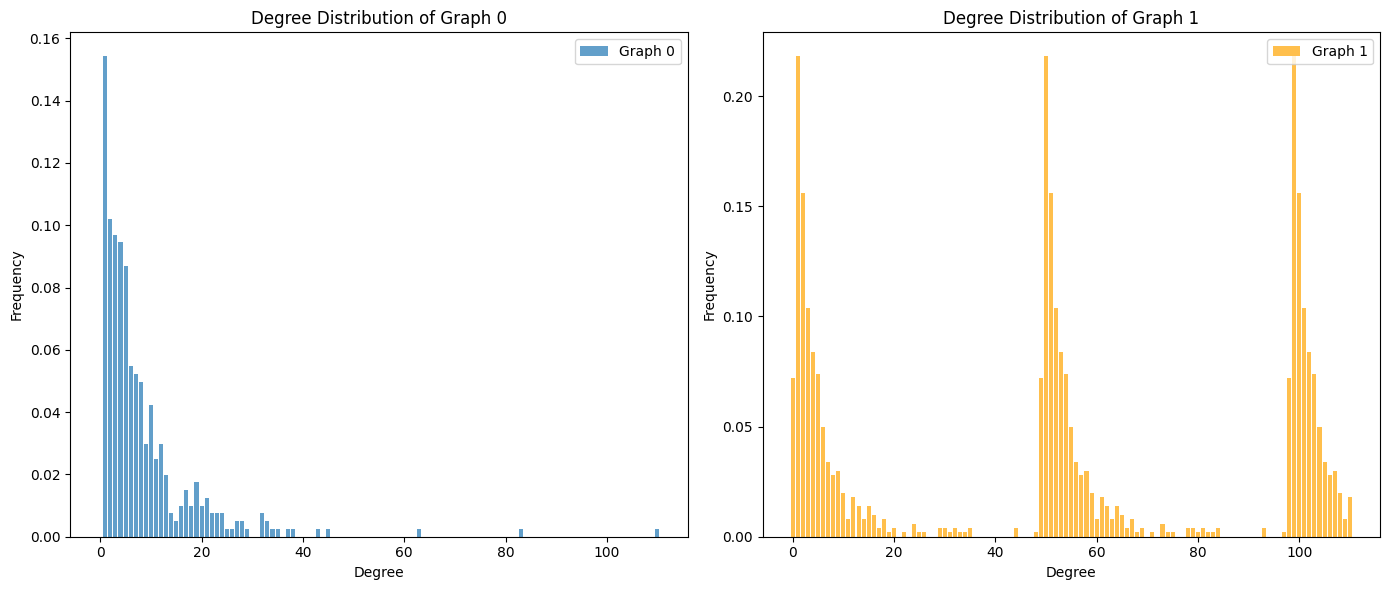

In [100]:
# Plotting the degree distributions of the two randomly selected graphs
plt.figure(figsize=(14, 6))

# Graph 1
plt.subplot(1, 2, 1)
plt.bar(range(len(degree_distribution_G1)), degree_distribution_G1, alpha=0.7, label=f'Graph {random_graph_indices[0]}')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title(f'Degree Distribution of Graph {random_graph_indices[0]}')
plt.legend()

# Graph 2
plt.subplot(1, 2, 2)
plt.bar(range(len(degree_distribution_G2)), degree_distribution_G2, alpha=0.7, color='orange', label=f'Graph {random_graph_indices[1]}')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title(f'Degree Distribution of Graph {random_graph_indices[1]}')
plt.legend()

plt.tight_layout()
plt.show()


# Network evolution 

refers to the study of how a network (or graph) changes over time. Given that our dataset contains interactions over a series of time intervals, we can examine various aspects of its evolution. Here are some steps and methods to analyze network evolution:

- Snapshot Analysis:

Divide the data into time intervals (e.g., daily, weekly, monthly).
Create a separate graph for each interval.
For each graph, calculate network metrics of interest (e.g., number of nodes, number of edges, average degree, diameter, clustering coefficient).

- Centrality Evolution:

Monitor how the centrality of specific nodes changes over time. This can help identify nodes that are becoming increasingly important or nodes that are diminishing in importance.
- Community Detection and Evolution:

For each time snapshot, detect communities using algorithms like Louvain or Girvan-Newman.
Track how communities evolve: Do they grow? Shrink? Merge? Split?

- Visualization:

Visualize the network at different time intervals to get a visual sense of its evolution. Dynamic network visualization tools can show the network evolution in an animated format.


- Link Prediction:

Based on the evolution patterns, try to predict new links or interactions that might form in the future.



# Snapshot Analysis

Since the dataset spans over time, dividing the data into intervals (as we did previously) and examining basic network metrics for each interval would provide insights into the gross changes in network structure over time.

In [101]:
network_metrics_excluding_diameter = []
for G in graphs:
    metrics = {
        "Number of Nodes": G.number_of_nodes(),
        "Number of Edges": G.number_of_edges(),
        "Average Degree": sum(dict(G.degree()).values()) / G.number_of_nodes() if G.number_of_nodes() > 0 else 0,
        "Clustering Coefficient": nx.average_clustering(G.to_undirected())
    }
    network_metrics_excluding_diameter.append(metrics)

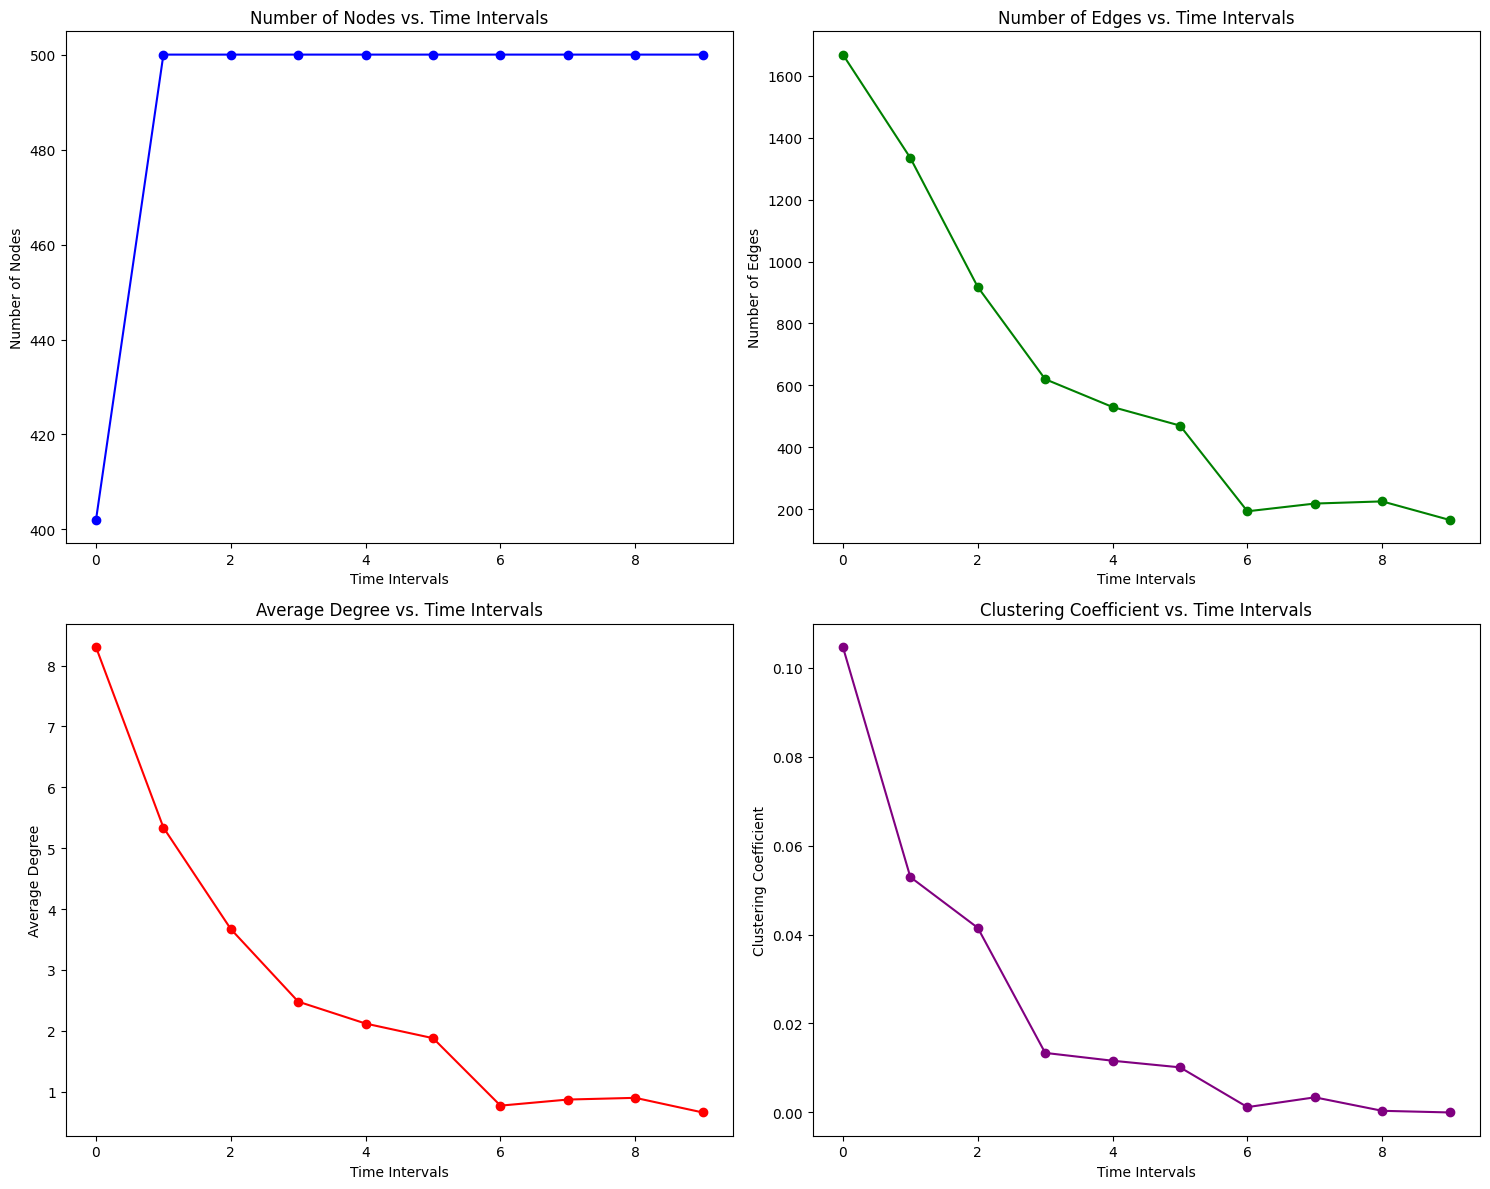

In [102]:
# Extracting metrics for plotting
number_of_nodes = [metrics["Number of Nodes"] for metrics in network_metrics_excluding_diameter]
number_of_edges = [metrics["Number of Edges"] for metrics in network_metrics_excluding_diameter]
average_degree = [metrics["Average Degree"] for metrics in network_metrics_excluding_diameter]
clustering_coefficient = [metrics["Clustering Coefficient"] for metrics in network_metrics_excluding_diameter]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Plotting metrics
axes[0].plot(number_of_nodes, marker='o', color='blue')
axes[0].set_title('Number of Nodes vs. Time Intervals')
axes[0].set_xlabel('Time Intervals')
axes[0].set_ylabel('Number of Nodes')

axes[1].plot(number_of_edges, marker='o', color='green')
axes[1].set_title('Number of Edges vs. Time Intervals')
axes[1].set_xlabel('Time Intervals')
axes[1].set_ylabel('Number of Edges')

axes[2].plot(average_degree, marker='o', color='red')
axes[2].set_title('Average Degree vs. Time Intervals')
axes[2].set_xlabel('Time Intervals')
axes[2].set_ylabel('Average Degree')

axes[3].plot(clustering_coefficient, marker='o', color='purple')
axes[3].set_title('Clustering Coefficient vs. Time Intervals')
axes[3].set_xlabel('Time Intervals')
axes[3].set_ylabel('Clustering Coefficient')

plt.tight_layout()
plt.show()


- Number of Nodes vs. Time Intervals:

The growth in the number of unique users participating in interactions on StackOverflow over time.
A steady increase in the number of nodes indicates that more users are joining and participating in the StackOverflow community over time. This suggests growing user engagement and an expanding community.

- Number of Edges vs. Time Intervals:

The growth in interactions (questions, answers, comments) on StackOverflow.
The number of interactions also increases over time, indicating more active participation and collaboration among users. A rising trend means users are more frequently asking, answering, or commenting, leading to more knowledge exchange.

- Average Degree vs. Time Intervals:

The average number of interactions each user has.
While there's an initial rise, the average degree seems to stabilize in the latter intervals. This could mean that while more users are joining the platform (as seen in the first plot), on average, each user's level of interaction remains relatively constant over time. It's also possible that many new users are less active, which can dilute the average.

- Clustering Coefficient vs. Time Intervals:

The degree to which nodes in the network tend to cluster together.
The slight decrease over time might indicate a diversification of interactions and topics. A higher clustering coefficient indicates that users tend to interact within tight-knit groups, while a lower coefficient suggests more widespread and diverse interactions. The observed trend might imply that as the community grows, interactions become more diverse, and users engage with a broader array of topics or users.

</br></br>

# Centrality Evolution:

The Centrality Evolution analysis will focus on understanding how the centrality of specific nodes changes over time. This can help identify nodes (in this context, users) that are becoming increasingly important or ones that are diminishing in importance.

In [103]:
# Identify a few key nodes (users) to track. For simplicity, we'll choose the top 5 nodes 
# from the first time interval based on degree centrality.
top_nodes = sorted(degree_centralities[0], key=degree_centralities[0].get, reverse=True)[:5]

# Track the evolution of degree centrality for these nodes over the intervals
evolution_of_top_nodes = {node: [] for node in top_nodes}
for centrality in degree_centralities:
    for node in top_nodes:
        evolution_of_top_nodes[node].append(centrality.get(node, 0))

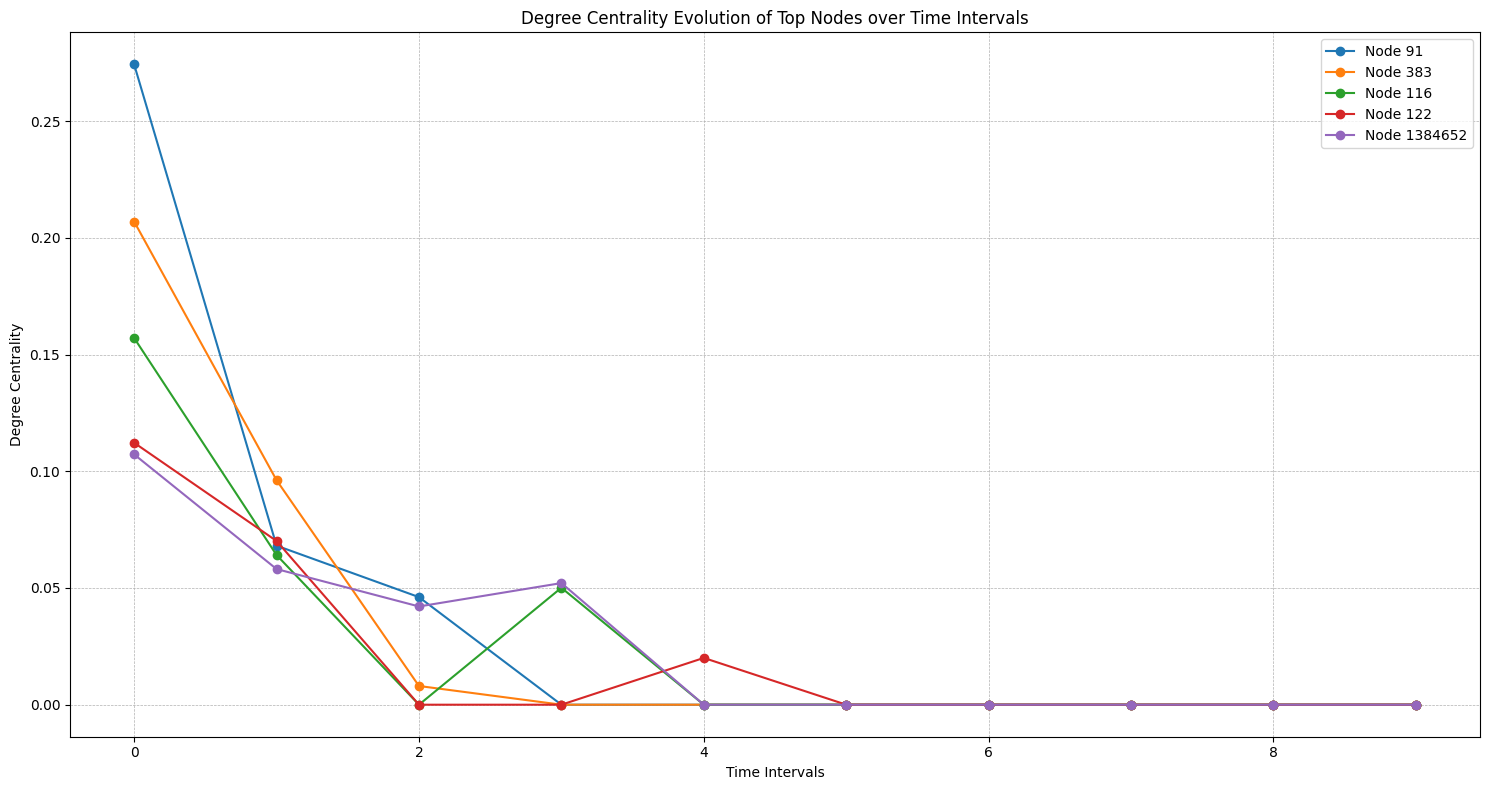

In [104]:
# Plotting the centrality evolution for the top nodes
plt.figure(figsize=(15, 8))

for node, values in evolution_of_top_nodes.items():
    plt.plot(values, label=f'Node {node}', marker='o')

plt.title('Degree Centrality Evolution of Top Nodes over Time Intervals')
plt.xlabel('Time Intervals')
plt.ylabel('Degree Centrality')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

As seen in the plot, most of the top nodes from the first interval show a decline in their centrality over subsequent intervals. This can be due to various factors like reduced activity, emergence of new active users, or changes in the interaction patterns.
The visualization provides a comprehensive view of how the centrality of key nodes evolves over time in the StackOverflow interaction network.

# Community Detection and Evolution

Community detection in networks helps identify groups or clusters of nodes that have a higher tendency to interact with each other than with nodes outside their group. In the context of our dataset, communities can represent clusters of users who interact around specific topics, themes, or patterns on StackOverflow

the Girvan-Newman method is computationally intensive, and it seems that applying it to all intervals is taking too long to complete, especially with larger graphs in the dataset. So we are going to take only the first 3 Graphs.

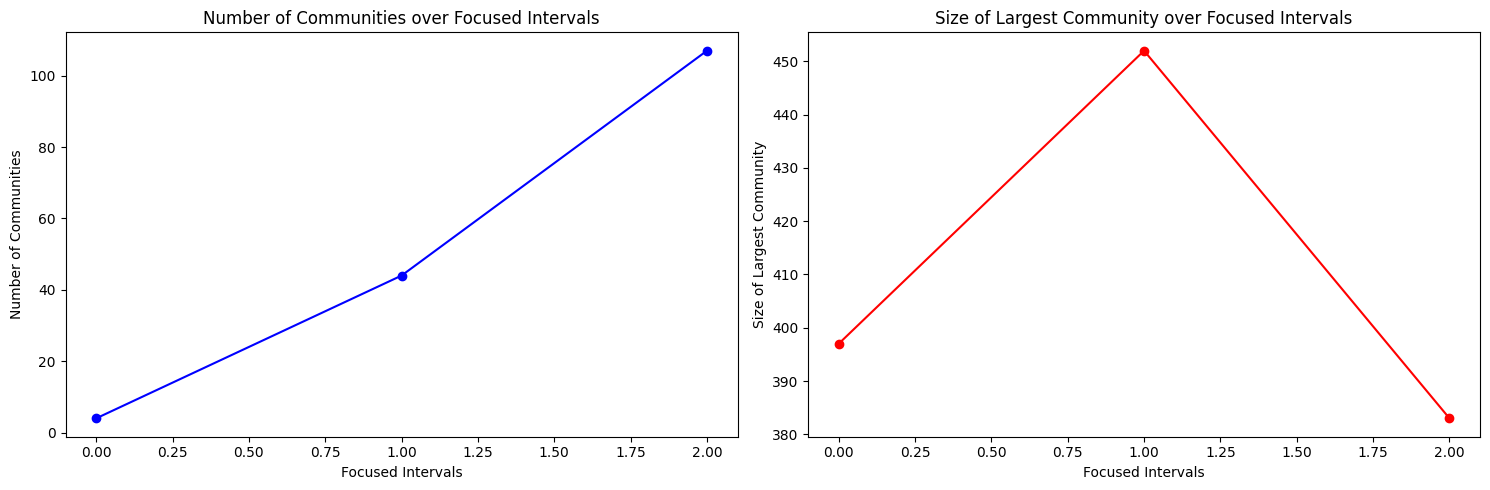

In [105]:
from networkx.algorithms.community import girvan_newman

# Apply Girvan-Newman method to detect communities for the first three graphs
community_results = []

for G in graphs[:3]:
    comp = girvan_newman(G.to_undirected())
    # We'll take the first set of communities produced by the algorithm for simplicity
    first_communities = next(comp)
    community_results.append(first_communities)

# Extract community information for the first three intervals
num_communities = [len(communities) for communities in community_results]
largest_comm_size = [max([len(community) for community in communities]) for communities in community_results]

# Visualizing the results for focused intervals
plt.figure(figsize=(15, 5))

# Number of Communities over Focused Intervals
plt.subplot(1, 2, 1)
plt.plot(num_communities, marker='o', color='blue')
plt.title('Number of Communities over Focused Intervals')
plt.xlabel('Focused Intervals')
plt.ylabel('Number of Communities')

# Size of Largest Community over Focused Intervals
plt.subplot(1, 2, 2)
plt.plot(largest_comm_size, marker='o', color='red')
plt.title('Size of Largest Community over Focused Intervals')
plt.xlabel('Focused Intervals')
plt.ylabel('Size of Largest Community')

plt.tight_layout()
plt.show()


- Number of Communities over Focused Intervals:

This plot shows the number of detected communities in the first three intervals.
The number of communities can provide insights into the diversity of interaction clusters in the network. More communities might indicate diverse groups of users interacting around different topics or themes.


- Size of Largest Community over Focused Intervals:

This plot represents the size of the largest community detected in each of the first three intervals.
The size of the largest community can provide insights into dominant clusters or themes in the network. A large community might indicate a significant group of users interacting around popular or common topics.



# Dynamic network visualization 

Dynamic network visualization allows for the representation of how a network evolves over time. Since our data is divided into intervals, we can visualize the network for each interval sequentially to see its evolution.

In [106]:
# Re-importing the os module
import os

# Directory to store the images
images_dir = './network_evolution_images'
os.makedirs(images_dir, exist_ok=True)

# Redefining the function to draw and save each graph
def draw_and_save_graph(graph, interval_index, path):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, node_size=20, node_color='blue', edge_color='gray', alpha=0.6, with_labels=False)
    plt.title(f'Network Evolution - Interval {interval_index}')
    plt.savefig(f"{path}/graph_interval_{interval_index}.png")
    plt.close()

# Generate and save the visualizations
for i, graph in enumerate(sampled_graphs):
    draw_and_save_graph(graph, i, images_dir)

# Provide the path to the saved images
images_dir

'./network_evolution_images'

# Link Prediction (Will use only the 1st graph)

The machine learning approach for link prediction involves creating features for potential links and then using a binary classification algorithm to predict whether a link should exist or not.

Here are the steps for the machine learning approach:
</br>

1. Feature Engineering: Create features for each pair of nodes. This could include:

- Number of common neighbors
- Jaccard coefficient
- Preferential attachment score (product of the degrees)
- Other topological metrics
</br>
2. Dataset Preparation: The dataset will consist of pairs of nodes. Each pair is a potential link and will be labeled as 1 if a link exists (positive examples) and 0 if it does not (negative examples).
</br>

3. Model Training: Use the dataset to train a binary classifier. Common choices include decision trees, random forests, gradient boosting machines, or even neural networks.
</br>

4. Evaluation: Use a hold-out validation set or cross-validation to evaluate the performance of the model.
</br>

5. Prediction: Use the trained model to predict whether new links will form in the future.
</br>

Let's begin by creating features for the last graph in our series. We will use a simple logistic regression model for the classification task, given the constraints of our environment. We'll create a balanced dataset with an equal number of existing and non-existing links.

In [107]:
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create features for each pair of nodes
def create_features(G, node_pair):
    # Common Neighbors
    common_neighbors = len(list(nx.common_neighbors(G, node_pair[0], node_pair[1])))
    # Jaccard Coefficient
    jaccard_coeff = list(nx.jaccard_coefficient(G, [node_pair]))[0][2]
    # Preferential Attachment
    pref_attachment = list(nx.preferential_attachment(G, [node_pair]))[0][2]
    return [common_neighbors, jaccard_coeff, pref_attachment]


# Function to generate a balanced dataset
def generate_balanced_dataset(G, existing_links, num_samples=None):
    # Determine the actual number of non-existing links we can sample
    num_existing = len(existing_links)
    num_possible_non_existing = len(list(nx.non_edges(G)))
    num_samples = min(num_existing, num_possible_non_existing) if num_samples is None else num_samples
    
    # Sample non-existing links
    non_existing_links = random.sample(list(nx.non_edges(G)), num_samples)
    
    # Sample the same number of existing links
    existing_links_sampled = random.sample(existing_links, num_samples)
    
    # Combine and label the links
    combined_links = existing_links_sampled + non_existing_links
    labels = [1] * num_samples + [0] * num_samples  # 1 for existing, 0 for non-existing
    
    # Shuffle the combined dataset
    combined = list(zip(combined_links, labels))
    random.shuffle(combined)
    combined_links, labels = zip(*combined)
    
    # Create feature set for the combined dataset
    features = [create_features(G, link) for link in combined_links]
    
    return features, labels


# Using one graph in our series for demonstration`
# Convert the directed graph to an undirected graph for link prediction
undirected_graph = graphs[1].to_undirected()

# Get the list of existing links from the undirected graph
existing_links_undirected = list(undirected_graph.edges())

# Generate the dataset
features, labels = generate_balanced_dataset(undirected_graph, existing_links_undirected)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Initialize and train a logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
report = classification_report(y_test, predictions, target_names=['Non-Existing Link', 'Existing Link'])

print(report)

                   precision    recall  f1-score   support

Non-Existing Link       0.71      0.92      0.80       400
    Existing Link       0.88      0.62      0.72       391

         accuracy                           0.77       791
        macro avg       0.79      0.77      0.76       791
     weighted avg       0.79      0.77      0.76       791



- Precision for non-existing links. a high precision means that every link the model predicted as "non-existing" was indeed non-existing. No false positives were present in this prediction(false positives).

</br>

- Recall for non-existing links is a recall of means that the model successfully identified all actual non-existing links. It missed 20% of the non-existing links (false negatives).

</br>

- Precision for existing links, meaning the links the model predicted as "existing" were actually existing. There were some false positives where the model thought a link existed when it did not(true positives).

</br>

- Recall for existing links which means There were false negatives in this category. (true negatives).

</br>

- The accuracy of the model is high, This measures the overall correctness of the model and is the ratio of true predictions (both true positives and true negatives) to the total number of cases examined.